In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd

In [17]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [24]:
#check columns in Measurement 
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = last_year[0]

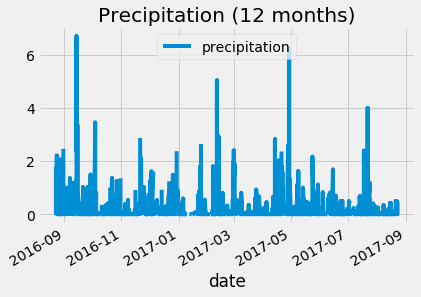

In [26]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(last_year, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')

# Set index to date
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.savefig("Images/Precip.png")
plt.show()

In [27]:
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [28]:
#check columns in Station 
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [29]:
# Design a query to show how many stations are available in this dataset?
station_total = session.query(Station.station).count()
station_total

9

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station=most_active_stations[0][0]
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_temps

[(54.0, 85.0, 71.66378066378067)]

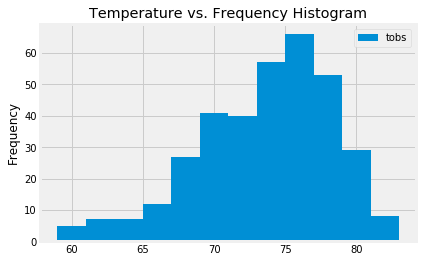

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_active_station).all()
temp_observations = pd.DataFrame(temp_observations, columns=['tobs'])

temp_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.savefig("Images/TempvsFreq.png")
plt.show()